# Predict slab dip

Predict the average slab dip, $\theta_{\mathrm{av}}$, of subducting oceanic lithosphere using the following plate kinematic parameters,

- $h_{\mathrm{plate}}$ is the thickness of the subducting plate calculated by plate models of lithospheric cooling (from [Grose, 2012](https://doi.org/10.1016/j.epsl.2012.03.037)).
- $v_{\mathrm{hsp}}$ is the rate of seafloor spreading that created the part of the oceanic plate now subducting
- $\rho_{\mathrm{av}}$ is the average density of the down-going plate.
- $v_c$ is the convergence velocity
- $v_t$ is the rate of trench migration

Using the present-day configuration of subduction boundaries and slab dips obtained from the Slab2 model ([Hayes _et al._, 2018](https://doi.org/10.1126/science.aat4723)), we use the `KNeighborsRegressor` object from the scikit-learn Python library to estimate slab dip through time.

#### References

- Grose, C. J. (2012). Properties of oceanic lithosphere: Revised plate cooling model predictions. Earth and Planetary Science Letters, 333–334, 250–264. https://doi.org/10.1016/j.epsl.2012.03.037
- Hayes, G. P., Moore, G. L., Portner, D. E., Hearne, M., Flamme, H., Furtney, M., & Smoczyk, G. M. (2018). Slab2, a comprehensive subduction zone geometry model. Science, 362(6410), 58–61. https://doi.org/10.1126/science.aat4723
- Clennett, E. J., Sigloch, K., Mihalynuk, M. G., Seton, M., Henderson, M. A., Hosseini, K., et al. (2020). A Quantitative Tomotectonic Plate Reconstruction of Western North America and the Eastern Pacific Basin. Geochemistry, Geophysics, Geosystems, 21(8), 1–25. https://doi.org/10.1029/2020GC009117
- Müller, R. D., Zahirovic, S., Williams, S. E., Cannon, J., Seton, M., Bower, D. J., et al. (2019). A Global Plate Model Including Lithospheric Deformation Along Major Rifts and Orogens Since the Triassic. Tectonics, 38(6), 1884–1907. https://doi.org/10.1029/2018TC005462

In [1]:
%matplotlib inline
import numpy as np
import glob, os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from gplately import pygplates
import gplately
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from scipy.stats import gaussian_kde
from scipy.spatial import cKDTree
from scipy import ndimage

from slabdip import SlabDipper
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Call GPlately's DataServer object and download the plate model
gdownload = gplately.download.DataServer("Clennett2020")
# rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# overwrite with more recent reconstructions
input_directory = "data/Global_Model_WD_Internal_Release_2019_v2_Clennett_NE_Pacific/"
rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model = pygplates.RotationModel(rotation_filenames)

coastlines = input_directory+"StaticGeometries/Coastlines/Global_coastlines_low_res.shp"
continents = input_directory+"StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp"
static_polygons = input_directory+"StaticGeometries/StaticPolygons/Clennett_2020_StaticPolygons.gpml"
COBs = input_directory+"StaticGeometries/COBLineSegments/Global_EarthByte_GeeK07_COBLineSegments_2019_v1.gpmlz"

topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
# coastlines, continents, COBs = gdownload.get_topology_geometries()

# Set time to present day for plotting
time = 0

# Call the PlotTopologies object
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs, time=time)

In [3]:
extent_globe = [-180,180,-90,90]

grid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = grid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"
spreadrate_filename = grid_dir+"SampleData/Rasters/spreadrate_grids/rategrid_final_mask_{:.0f}.nc"

## Object for predicting slab dip

In [4]:
df = pd.read_csv("data/subduction_data.csv", index_col=0)

# remove NaN entries
df = df[np.isfinite(df['slab_dip'])]

variable_names = ['angle', 'total_vel', 'vel', 'trench_vel', 'vratio', 'slab_age', 'slab_thickness',
                  'spreading_rate', 'density']

df_X_train = df[variable_names]
df_y_train = df['slab_dip']

In [5]:
mlp = MLPRegressor(hidden_layer_sizes=(50,), solver='lbfgs', max_iter=3000, tol=0.05)
kn = KNeighborsRegressor(n_neighbors=3)

dipper = SlabDipper(sklearn_regressor=kn, X=df_X_train, y=df_y_train)
dipper.model = model
dipper.set_age_grid_filename(agegrid_filename)
dipper.set_spreading_rate_grid_filename(spreadrate_filename)
dipper.get_score()

0.9245808656536854

In [6]:
df_time = dipper.tessellate_slab_dip(0)

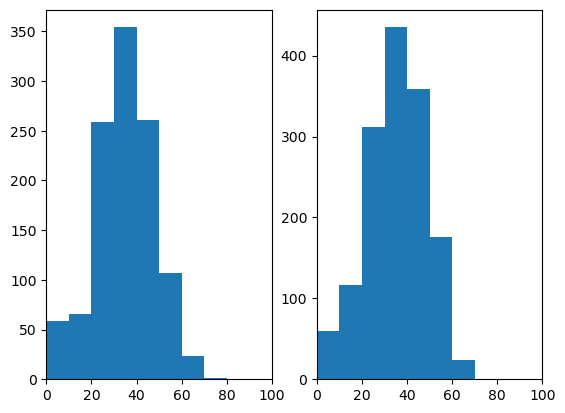

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hist(df['slab_dip'], bins=10, range=(0,100))
ax2.hist(df_time['slab_dip'], bins=10, range=(0,100))

for ax in [ax1,ax2]:
    ax.set_xlim(0,100)

In [8]:
df.describe()

,lon,lat,angle,norm,pid_sub,pid_over,length,total_vel,vel,trench_vel,...,slab_flux,slab_age,slab_thickness,vratio,slab_dip,segment_ID,curvature,density,relative_density,spreading_rate
count,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,...,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000
mean,26.513316,9.557946,0.621437,168.240638,1290.280531,77832.769912,42205.628815,0.057107,0.050428,-0.010151,...,3512.602722,72.255141,72629.339973,0.788405,35.122807,26.053097,0.000015,3282.444222,-17.555778,0.039740
std,118.466534,28.620140,39.052331,120.727691,12639.826511,160984.759423,11299.777943,0.043068,0.032284,0.024077,...,2630.354925,56.213458,27135.798264,0.271681,12.738036,14.859687,0.000244,58.134206,58.134206,0.025835
min,-179.937538,-60.675510,-167.067827,1.451468,101.000000,101.000000,774.618467,-0.134422,0.000000,-0.104441,...,0.000000,0.000000,0.000000,0.000000,1.061921,0.000000,-0.000655,2900.000000,-400.000000,0.000590
25%,-79.468352,-9.467675,-22.315619,54.637442,674.000000,645.000000,35912.523102,0.032455,0.021181,-0.019674,...,1189.563549,25.344196,51860.094070,0.681773,27.848783,12.000000,-0.000033,3273.375728,-26.624272,0.020264
50%,34.005493,6.829991,0.905115,130.527140,838.000000,736.000000,45335.757018,0.062861,0.052038,-0.007488,...,3166.032322,53.819028,75416.803360,0.906602,35.973342,25.000000,-0.000002,3301.232936,1.232936,0.037076
75%,137.512715,35.776461,21.602225,291.396023,901.000000,12001.000000,50503.323104,0.088453,0.073047,0.005169,...,5472.525506,116.821843,99084.019661,1.000000,43.517157,39.000000,0.000036,3312.805448,12.805448,0.056310
max,179.426407,60.451013,168.336842,359.685144,301300.000000,714004.000000,55597.541862,0.168125,0.145023,0.054192,...,12253.404369,216.165560,105298.280716,1.000000,71.382011,48.000000,0.003373,3314.500778,14.500778,0.167724


/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


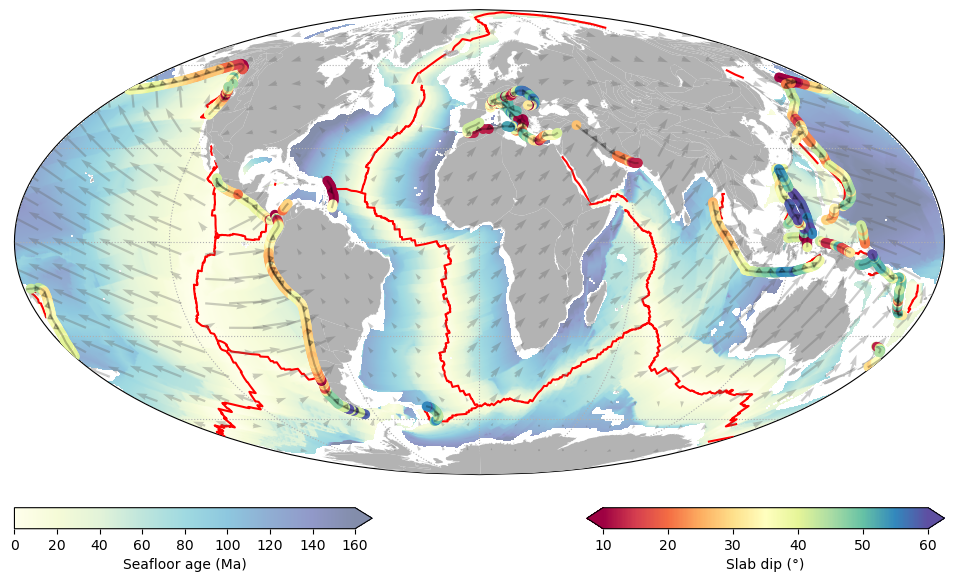

In [9]:
# Create a figure
fig = plt.figure(figsize=(12,7))
gs = GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])

ax = fig.add_subplot(gs[0,:], projection=ccrs.Mollweide(central_longitude=0))
ax.set_global()


age_raster = gplately.Raster(filename=agegrid_filename.format(gplot.time))
im = gplot.plot_grid(ax, age_raster.data, cmap='YlGnBu', alpha=0.5, vmin=0, vmax=160, zorder=1)

gplot.plot_ridges_and_transforms(ax, color='r', zorder=3)
# gplot.plot_misc_boundaries(ax, color='r', zorder=3)
gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.33, zorder=7, regrid_shape=20)
gplot.plot_coastlines(ax, facecolor='0.7', edgecolor='none', zorder=3)
gplot.plot_trenches(ax, alpha=0.25, zorder=9)
gplot.plot_subduction_teeth(ax, alpha=0.25, zorder=9)


sc0 = ax.scatter(df_time['lon'], df_time['lat'], c=df_time['slab_dip'], cmap='Spectral', vmin=10, vmax=60,
                 transform=ccrs.PlateCarree(), rasterized=True, zorder=8)

ax.gridlines(linestyle=':')


cax1 = fig.add_subplot(gs[1,0])
cax2 = fig.add_subplot(gs[1,1])

# fig.colorbar(im, shrink=0.4, label='Slab depth (km)')
fig.colorbar(sc0, cax=cax2, orientation='horizontal', label='Slab dip (°)', extend='both')
fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max')

fig.savefig("slab_dip_0Ma.pdf", bbox_inches='tight', dpi=300)
fig.savefig("slab_dip_0Ma.png", bbox_inches='tight', dpi=300)

/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


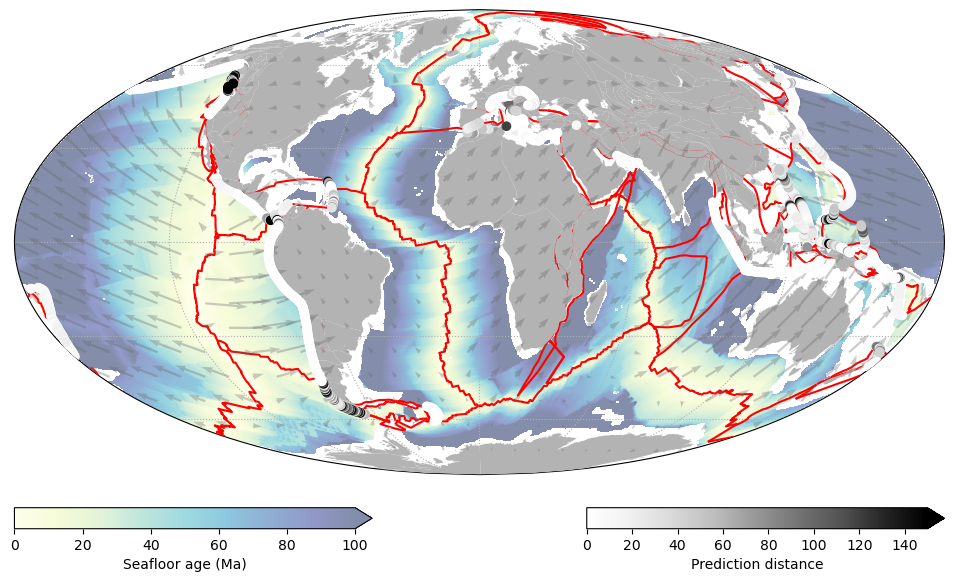

In [10]:

# Create a figure

fig = plt.figure(figsize=(12,7))
gs = GridSpec(2,2, hspace=0.05, wspace=0.6, height_ratios=[0.96,0.04])

ax = fig.add_subplot(gs[0,:], projection=ccrs.Mollweide(central_longitude=0))
ax.set_global()

age_raster = gplately.Raster(filename=agegrid_filename.format(gplot.time))
im = gplot.plot_grid(ax, age_raster.data, cmap='YlGnBu', alpha=0.5, vmin=0, vmax=100, zorder=1)

gplot.plot_ridges_and_transforms(ax, color='r', zorder=3)
gplot.plot_misc_boundaries(ax, color='r', zorder=3)
gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.33, zorder=7, regrid_shape=20)
gplot.plot_coastlines(ax, facecolor='0.7', edgecolor='none', zorder=3)
# gplot.plot_trenches(ax, zorder=9)
# gplot.plot_subduction_teeth(ax, zorder=9)

sc0 = ax.scatter(df_time['lon'], df_time['lat'], c=df_time['prediction_distance'], cmap='Greys', vmin=0,vmax=150,
                 transform=ccrs.PlateCarree(), rasterized=True, zorder=8)

ax.gridlines(linestyle=':')


cax1 = fig.add_subplot(gs[1,0])
cax2 = fig.add_subplot(gs[1,1])

# fig.colorbar(im, shrink=0.4, label='Slab depth (km)')
fig.colorbar(sc0, cax=cax2, orientation='horizontal', label='Prediction distance', extend='max')
fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max')